# Introduction

This notebook will focus primarily statistical side of the time series modelling, including how to define Correlation's, the concept of Stationarity, Auto-Correlation & Partial Auto-Correlation Function, Auto-Regressive & Moving Average Processes in modelling and how to perform Model Diagnostics.

<b>Interesting Read : </b>[Engineering Statistics Handbook](https://www.itl.nist.gov/div898/handbook/index.htm)

<img src='../Materials/Engineering Statistic Handbook - Cover.png' width='250' align='left'>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

[R - Libraries : Some useful libraries and components for Time Series Analysis in R - by Rob.J.Hyndman](https://cran.r-project.org/web/views/TimeSeries.html)

# Imports

In [8]:
# General
from warnings import filterwarnings
filterwarnings('ignore')
from cycler import cycler

# Data Wrangling
import pandas as pd
import numpy as np

# Data Viualization
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpl

# Time Series Specific
from statsmodels.tsa.seasonal import seasonal_decompose

# Datetime
from datetime import datetime

# DataHandler
from helperhandler import dataHolder

# Path and Variable Initialisation

In [5]:
root_path = '../'
raw_datapath = root_path+'Raw Data/'
prepared_datapath = root_path+'Prepared Data/'

In [6]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (15,7)
plt.style.use('dark_background')
# plt.style.use('ggplot')

# Loading & Exploring the data

In [3]:
dataHolder.load_data()

In [4]:
dataHolder.dataDf

,Handle,Short Description
0,airp_data,Air Passengers
1,mprod_data,Milk Production
2,brit_stock,Britannia Stock Price
3,india_cpi,India CPI
4,beer_prod,Beer Production
5,house_price,Housing Prices
6,airp_data_missing,Air Passengers - Missing
7,housing_missing,Housing Data - Missing
8,pop_ener,Population & Energy
9,usa_cpi,USA-CPI


In [407]:
dataHolder.bucket

{'airp_data': <helperhandler._databucket.DataProcessingClass at 0x7fb15afbcca0>,
 'mprod_data': <helperhandler._databucket.DataProcessingClass at 0x7fb15afbcdf0>,
 'brit_stock': <helperhandler._databucket.DataProcessingClass at 0x7fb15afbce20>,
 'india_cpi': <helperhandler._databucket.DataProcessingClass at 0x7fb15afbcd30>,
 'beer_prod': <helperhandler._databucket.DataProcessingClass at 0x7fb15afbce80>,
 'house_price': <helperhandler._databucket.DataProcessingClass at 0x7fb15afec940>,
 'airp_data_missing': <helperhandler._databucket.DataProcessingClass at 0x7fb15afec970>,
 'housing_missing': <helperhandler._databucket.DataProcessingClass at 0x7fb15afec9a0>,
 'pop_ener': <helperhandler._databucket.DataProcessingClass at 0x7fb15afec9d0>,
 'usa_cpi': <helperhandler._databucket.DataProcessingClass at 0x7fb15afeca00>,
 'anti_diabetic': <helperhandler._databucket.DataProcessingClass at 0x7fb15afeca30>,
 'aus_elecprod': <helperhandler._databucket.DataProcessingClass at 0x7fb15afeca60>,
 'visi

# Splitting Data

There is a need to split the data such that we land with three buckets of the Data:-

- Train, CV & Test Splits
    - Training Data - Data that the Model Learns upon
    - Cross Validation Data - Data on which we determine our hyperparameters/parameters of the model on
    - Test Data - Data on which we measure our `Metrics` as to how the model is doing on a dataset which it has never seen before, neither in Training or in Cross Validation Phase.

<img src='../Materials/SimpleTrainTestSplit.png'>

****
- Rolling Splits

Usually time series models that are built, are statistical based and in some cases mahine learning or deep learning based, but either ways these models are not that heavy that re-reunning these models every month to generate forecasts will be Computationally expensive, or atleast that is and has been true for most of the cases.

<img src='../Materials/SimpleRollingForecast.png' align='left' width='460'>
<img src='../Materials/SimpleRollingForecastWithStepAhead.png' align='left' width='460'>

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
Credit : https://otexts.com/fpp2/accuracy.html


In [12]:
def generat_randomtsdata(tstart = '1990-01-01', tend = '2020-01-01', plot=False):
    rows = (pd.to_datetime(tend)-pd.to_datetime(tstart)).days+1
    simData = pd.DataFrame(columns=['Trend',  'Cyclicity', 'Seasonality', 'Residual'],
                           index=pd.date_range(tstart, tend, freq='1D'))
    
    _days=np.arange(rows)

    # Trend Componet
    simData['Trend'] = 2*np.arange(rows)/rows
    # Cyclicity Componet
    simData['Cyclicity'] = 0.3*np.sin(3*_days/rows * 2 * np.pi)
    # Seasonality - For Additive
    simData['Seasonality'] = 0.3*np.sin(_days/365 * 2 * np.pi)
    # Seasonality - For Multiplicative
    simData['Seasonality'] = 0.3*(_days/rows)*np.sin(_days/365 * 2 * np.pi)
    # Residual
    simData['Residual'] = np.random.random(rows)/10
    # Time Series
    simData['ts'] = simData.sum(axis=1)
    
    if plot : get_decompose_plot(simData)
    
    return simData


In [14]:
simData = generat_randomtsdata()
simData.head()

,Trend,Cyclicity,Seasonality,Residual,ts
1990-01-01,0.000000,0.000000,0.000000e+00,0.059040,0.059040
1990-01-02,0.000183,0.000516,4.712545e-07,0.029232,0.029931
1990-01-03,0.000365,0.001032,1.884739e-06,0.011650,0.013049
1990-01-04,0.000548,0.001548,4.239615e-06,0.089607,0.091707
1990-01-05,0.000730,0.002064,7.534487e-06,0.043756,0.046558


<b>TCT Split</b>

In [33]:
# Ratios
training_ratio = 0.8 
cv_ratio = 0.1

In [34]:
training = int(training_ratio*simData.shape[0])
cv = int(cv_ratio*simData.shape[0])
test = simData.shape[0]-training-cv

training_data = simData.iloc[:training, :]
cv_data = simData.iloc[training:training+cv, :]
test_data = simData.iloc[-test:, :]

training_data.shape, cv_data.shape, test_data.shape

((8766, 5), (1095, 5), (1097, 5))

In [35]:
print('Training Data ranges from {0} to {1}'.format(training_data.index.min(),
                                                    training_data.index.max()))
print('Cross Validation Data ranges from {0} to {1}'.format(cv_data.index.min(),
                                                            cv_data.index.max()))
print('Testing Data ranges from {0} to {1}'.format(test_data.index.min(),
                                                   test_data.index.max()))

Training Data ranges from 1990-01-01 00:00:00 to 2013-12-31 00:00:00
Cross Validation Data ranges from 2014-01-01 00:00:00 to 2016-12-30 00:00:00
Testing Data ranges from 2016-12-31 00:00:00 to 2020-01-01 00:00:00


<b>Rolling Splits</b>

In [46]:
# Parameters
test_start = '2014-01-01'
ahead = 0
dfreq = 'D'


In [49]:
train_cv_data = simData[simData.index<test_start]
test_data  = simData[simData.index>=test_start]

print('Training-CV Data ranges from {0} to {1}'.format(train_cv_data.index.min(),
                                                       train_cv_data.index.max()))
print('Testing Data ranges from {0} to {1}'.format(test_data.index.min(),
                                                   test_data.index.max()))

Training-CV Data ranges from 1990-01-01 00:00:00 to 2013-12-31 00:00:00
Testing Data ranges from 2014-01-01 00:00:00 to 2020-01-01 00:00:00


In [97]:
from sklearn.linear_model import LinearRegression

In [211]:
def train_model(traincv_data, test_data, 
                cv_window, ahead_offest,
                target_col, feature_cols,
                metric_func, metric='MAPE',):
    
    traincv_data.sort_index(inplace=True)
    cvDF = pd.DataFrame(columns = ['Actual', 'Forecast', metric])
    testDF = pd.DataFrame(columns=['Actual', 'Forecast', metric])
    
    feat_cols = feature_cols
    model = None
    
    # Prepare Dates
    tstart_date = traincv_data.index[0]
    for tend_date in train_cv_data.index[-cv_window:]:
        point_date = tend_date+ahead_offest
        #print('Training Start Date : ', tstart_date.strftime('%Y-%m-%d'))
        #print('Training End Date : ', tend_date.strftime('%Y-%m-%d'))
        #print('Point Forecast Date : ', point_date.strftime('%Y-%m-%d')+'\n\n')
        
        # Filter the data
        _train_data = train_cv_data.truncate(before=tstart_date, after=tend_date)
        _cv_data = train_cv_data.loc[point_date].to_frame().T
        # Get X & Y
        _train_dataX = _train_data[feat_cols]
        _train_dataY = _train_data[target_col]
        
        _cv_dataX = _cv_data[feat_cols]
        _cv_dataY = _cv_data[target_col]
        
        
        # Fit your model on the _train_data
        # -------------FILL--------------
        model = LinearRegression()
        # Test your model on the _cv_data
        # -------------FILL--------------
        model.fit(_train_dataX, _train_dataY)
        # Calculate the metric for _cv_data
        # forecast and fill cvDF
        # -------------FILL--------------
        _forecast = model.predict(_cv_dataX)[0]
        _actual = _cv_dataY.values[0]

        cvDF.loc[point_date, 'Actual'] = _actual
        cvDF.loc[point_date, 'Forecast'] = _forecast
        cvDF.loc[point_date,  metric] = metric_func(_actual, _forecast)
        
    # Forecast on the Test Data
    _test_dataX = test_data[feat_cols]
    _test_dataY = test_data[target_col]
    testDF['Actual'] = _test_dataY
    testDF['Forecast'] = model.predict(_test_dataX)
    testDF[metric] = testDF.apply(lambda x : metric_func(x.Actual, x.Forecast), axis=1)
    
    return cvDF, testDF


In [212]:
mape_func=lambda y,yhat: np.round(100*(abs(y-yhat)/y),2)


res = train_model(traincv_data = train_cv_data, test_data = test_data,
                  cv_window = 50, ahead_offest = pd.DateOffset(days=0),
                  feature_cols = ['Trend', 'Seasonality'], target_col = 'ts',
                  metric='MAPE(%)', metric_func=mape_func)

cv_metric_sheet, test_metric_sheet = res


In [213]:
cv_metric_sheet.head()

,Actual,Forecast,MAPE(%)
2013-11-12,1.6444,1.50633,8.4
2013-11-13,1.66986,1.50956,9.6
2013-11-14,1.71761,1.51287,11.92
2013-11-15,1.68491,1.5162,10.01
2013-11-16,1.7147,1.51958,11.38


In [214]:
test_metric_sheet.head()

,Actual,Forecast,MAPE(%)
2014-01-01,1.890272,1.703807,9.86
2014-01-02,1.832819,1.707988,6.81
2014-01-03,1.820125,1.712162,5.93
2014-01-04,1.875289,1.716327,8.48
2014-01-05,1.888589,1.720482,8.90


In [215]:
print('MAPE for Cross Validation : ', np.round(cv_metric_sheet.iloc[:,-1].mean(),3))
print('MAPE for Test Data        : ', np.round(test_metric_sheet.iloc[:,-1].mean(),3))

MAPE for Cross Validation :  9.206
MAPE for Test Data        :  12.043


# Residual Diagnostics

Residual in a Time Series Model is what is left over after the Forecast, i.e `residual=Actual-Forecast`

Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will yield residuals with the following properties:

- The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
- The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.
- The residuals have constant variance.
- The residuals are normally distributed.

In [200]:
from statsmodels.graphics.tsaplots import plot_acf
def residual_diagnostic(metric_sheet):
    metric_sheet=metric_sheet.copy()
    metric_sheet['Residuals'] = metric_sheet.Actual-metric_sheet.Forecast

    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['figure.figsize'] = (15,12)
    plt.style.use('dark_background')

    grid = plt.GridSpec(2, 2, wspace=0.1, hspace=0.2)
    series_ax = plt.subplot(grid[0:1, :])
    series_ax.set_title('Residuals')
    metric_sheet['Residuals'].plot(ax=series_ax)

    dist_ax = plt.subplot(grid[1, 0])
    dist_ax.set_title('Residual Distribution')
    sns.distplot(metric_sheet['Residuals'], ax=dist_ax, rug=True, rug_kws={'color':'r'})

    acf_ax = plt.subplot(grid[1, 1])
    acf_ax.set_title('Auto-Correlation')
    _=plot_acf(metric_sheet['Residuals'], ax=acf_ax)
    


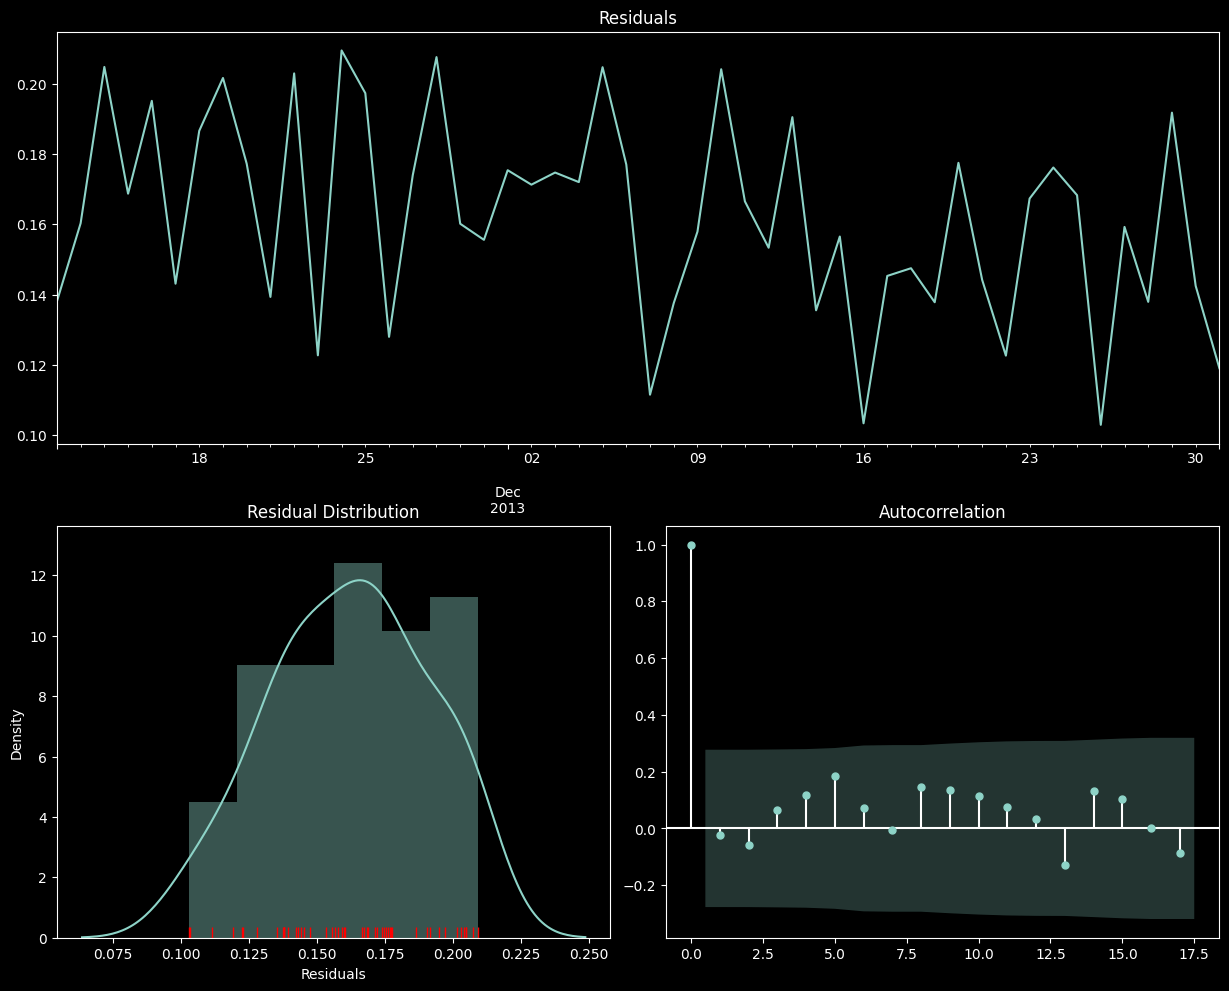

In [201]:
residual_diagnostic(cv_metric_sheet)

# Simple Univariate Models

- Average Model : Taking Average of the Available Data
- Näive Model : The Prior Value is your next Vaue
- Seasonal Näive Model : Give the Same Value as Prior Season, i.e Forecast for Jan-2020 will be the value of Jan-2019


<b>Average Model</b>

In [374]:
def train_model(traincv_data, test_data, 
                cv_window, ahead_offest,
                target_col,
                metric_func, metric='MAPE',):
    
    comb_data = pd.concat([traincv_data, test_data])
    traincv_data.sort_index(inplace=True)
    cvDF = pd.DataFrame(columns = ['Actual', 'Forecast', metric])
    testDF = pd.DataFrame(columns=['Actual', 'Forecast', metric])
    
    # Prepare Dates
    tstart_date = traincv_data.index[0]
    for tend_date in traincv_data.index[-cv_window:]:
        point_date = tend_date+ahead_offest
        
        # Filter the data
        _train_data = traincv_data.truncate(before=tstart_date, after=tend_date)
        _cv_data = traincv_data.loc[point_date].to_frame().T
        
        _train_dataY = _train_data[target_col]
        _cv_dataY = _cv_data[target_col]

        _forecast = _train_dataY.mean()
        _actual = _cv_dataY.values[0]

        cvDF.loc[point_date, 'Actual'] = _actual
        cvDF.loc[point_date, 'Forecast'] = _forecast
        cvDF.loc[point_date,  metric] = metric_func(_actual, _forecast)
        
    # Forecast on the Test Data
    _test_dataY = test_data[target_col]
    testDF['Actual'] = _test_dataY
    testDF['Forecast'] = comb_data.expanding().mean()
    testDF[metric] = testDF.apply(lambda x : metric_func(x.Actual, x.Forecast), axis=1)
    
    return cvDF, testDF



In [375]:
mape_func=lambda y,yhat: np.round(100*(abs(y-yhat)/y),2)


res = train_model(traincv_data = train_cv_data, test_data = test_data,
                  cv_window = 1000, ahead_offest = pd.DateOffset(days=0),
                  target_col = 'ts',
                  metric='MAPE(%)', metric_func=mape_func)

avg_cvmsheet, avg_tmsheet = res
print('MAPE for Cross Validation : ', np.round(avg_cvmsheet.iloc[:,-1].mean(),3))
print('MAPE for Test Data        : ', np.round(avg_tmsheet.iloc[:,-1].mean(),3))

MAPE for Cross Validation :  53.88
MAPE for Test Data        :  46.261


<b>Näive Model</b>

In [376]:
def train_model(traincv_data, test_data, 
                cv_window, ahead_offest,
                target_col,
                metric_func, metric='MAPE'):
    
    comb_data = pd.concat([traincv_data, test_data])
    traincv_data.sort_index(inplace=True)
    cvDF = pd.DataFrame(columns = ['Actual', 'Forecast', metric])
    testDF = pd.DataFrame(columns=['Actual', 'Forecast', metric])
    
    # Prepare Dates
    tstart_date = traincv_data.index[0]
    for tend_date in traincv_data.index[-cv_window:-1]:
        point_date = tend_date+ahead_offest
        
        # Filter the data
        _train_data = traincv_data.truncate(before=tstart_date, after=tend_date)
        _cv_data = traincv_data.loc[point_date].to_frame().T
        
        _train_dataY = _train_data[target_col]
        _cv_dataY = _cv_data[target_col]

        _forecast = _train_dataY[-1]
        _actual = _cv_dataY.values[0]

        cvDF.loc[point_date, 'Actual'] = _actual
        cvDF.loc[point_date, 'Forecast'] = _forecast
        cvDF.loc[point_date,  metric] = metric_func(_actual, _forecast)

    # Forecast on the Test Data
    _prev_dt = test_data.index-ahead_offest
    _test_dataY = test_data[target_col]
    testDF['Actual'] = _test_dataY
    testDF['Forecast'] = comb_data.truncate(_prev_dt.min(), _prev_dt.max())[target_col].values
    testDF[metric] = testDF.apply(lambda x : metric_func(x.Actual, x.Forecast), axis=1)
    
    return cvDF, testDF


In [377]:
mape_func=lambda y,yhat: np.round(100*(abs(y-yhat)/y),2)


res = train_model(traincv_data = train_cv_data, test_data = test_data,
                  cv_window = 1000, ahead_offest = pd.DateOffset(days=1),
                  target_col = 'ts',
                  metric='MAPE(%)', metric_func=mape_func)

naive_cvmsheet, naive_tmsheet = res
print('MAPE for Cross Validation : ', np.round(naive_cvmsheet.iloc[:,-1].mean(),3))
print('MAPE for Test Data        : ', np.round(naive_tmsheet.iloc[:,-1].mean(),3))


MAPE for Cross Validation :  1.853
MAPE for Test Data        :  2.009


<b>Seasonal Näive Model</b>

In [378]:
def train_model(traincv_data, test_data, 
                cv_window, ahead_offest,
                target_col,
                metric_func, metric='MAPE',):
    
    comb_data = pd.concat([traincv_data, test_data])
    traincv_data.sort_index(inplace=True)
    cvDF = pd.DataFrame(columns = ['Actual', 'Forecast', metric])
    testDF = pd.DataFrame(columns=['Actual', 'Forecast', metric])
    
    # Prepare Dates
    tstart_date = traincv_data.index[0]
    for tend_date in traincv_data.index[-cv_window:-1]:
        point_date = tend_date+ahead_offest

        # Filter the data
        _train_data = traincv_data.loc[point_date-pd.DateOffset(months=12)]
        
        _cv_data = traincv_data.loc[point_date].to_frame().T
        
        _cv_dataY = _cv_data[target_col]

        _forecast = _train_data[target_col]
        _actual = _cv_dataY.values[0]

        cvDF.loc[point_date, 'Actual'] = _actual
        cvDF.loc[point_date, 'Forecast'] = _forecast
        cvDF.loc[point_date,  metric] = metric_func(_actual, _forecast)

    #Forecast on the Test Data
    _prev_seasondt = test_data.index-pd.DateOffset(months=12)
    
    _test_dataY = test_data[target_col]
    testDF['Actual'] = _test_dataY
    testDF['Forecast'] = comb_data.truncate(_prev_seasondt.min(), _prev_seasondt.max())[target_col].values
    testDF[metric] = testDF.apply(lambda x : metric_func(x.Actual, x.Forecast), axis=1)
    
    return cvDF, testDF


In [379]:
mape_func=lambda y,yhat: np.round(100*(abs(y-yhat)/y),2)

res = train_model(traincv_data = train_cv_data, test_data = test_data,
                  cv_window = 1000, ahead_offest = pd.DateOffset(days=0),
                  target_col = 'ts',
                  metric='MAPE(%)', metric_func=mape_func)

snaive_cvmsheet, snaive_tmsheet = res
print('MAPE for Cross Validation : ', np.round(snaive_cvmsheet.iloc[:,-1].mean(),3))
print('MAPE for Test Data        : ', np.round(snaive_tmsheet.iloc[:,-1].mean(),3))


MAPE for Cross Validation :  6.516
MAPE for Test Data        :  6.418


In [405]:
combined_msheet = simData[['ts']].copy()
combined_msheet.columns = ['Actual']

combined_msheet['Average CV'] = avg_cvmsheet.Forecast
combined_msheet['Average Test'] = avg_tmsheet.Forecast
combined_msheet['Average UL'] = avg_tmsheet.Forecast+1.96*avg_tmsheet.Forecast.expanding().var()
combined_msheet['Average LL'] = avg_tmsheet.Forecast-1.96*avg_tmsheet.Forecast.expanding().var()

combined_msheet['Naive CV'] = naive_cvmsheet.Forecast
combined_msheet['Naive Test'] = naive_tmsheet.Forecast
combined_msheet['Naive UL'] = naive_tmsheet.Forecast+1.96*naive_tmsheet.Forecast.expanding().var()
combined_msheet['Naive LL'] = naive_tmsheet.Forecast-1.96*naive_tmsheet.Forecast.expanding().var()

combined_msheet['Seasonal Naive CV'] = snaive_cvmsheet.Forecast
combined_msheet['Seasonal Naive Test'] = snaive_tmsheet.Forecast
combined_msheet['Seasonal Naive UL'] = snaive_tmsheet.Forecast+1.96*snaive_tmsheet.Forecast.expanding().var()
combined_msheet['Seasonal Naive LL'] = snaive_tmsheet.Forecast-1.96*snaive_tmsheet.Forecast.expanding().var()
combined_msheet.head()

combined_msheet = combined_msheet.iloc[-4000:,:]


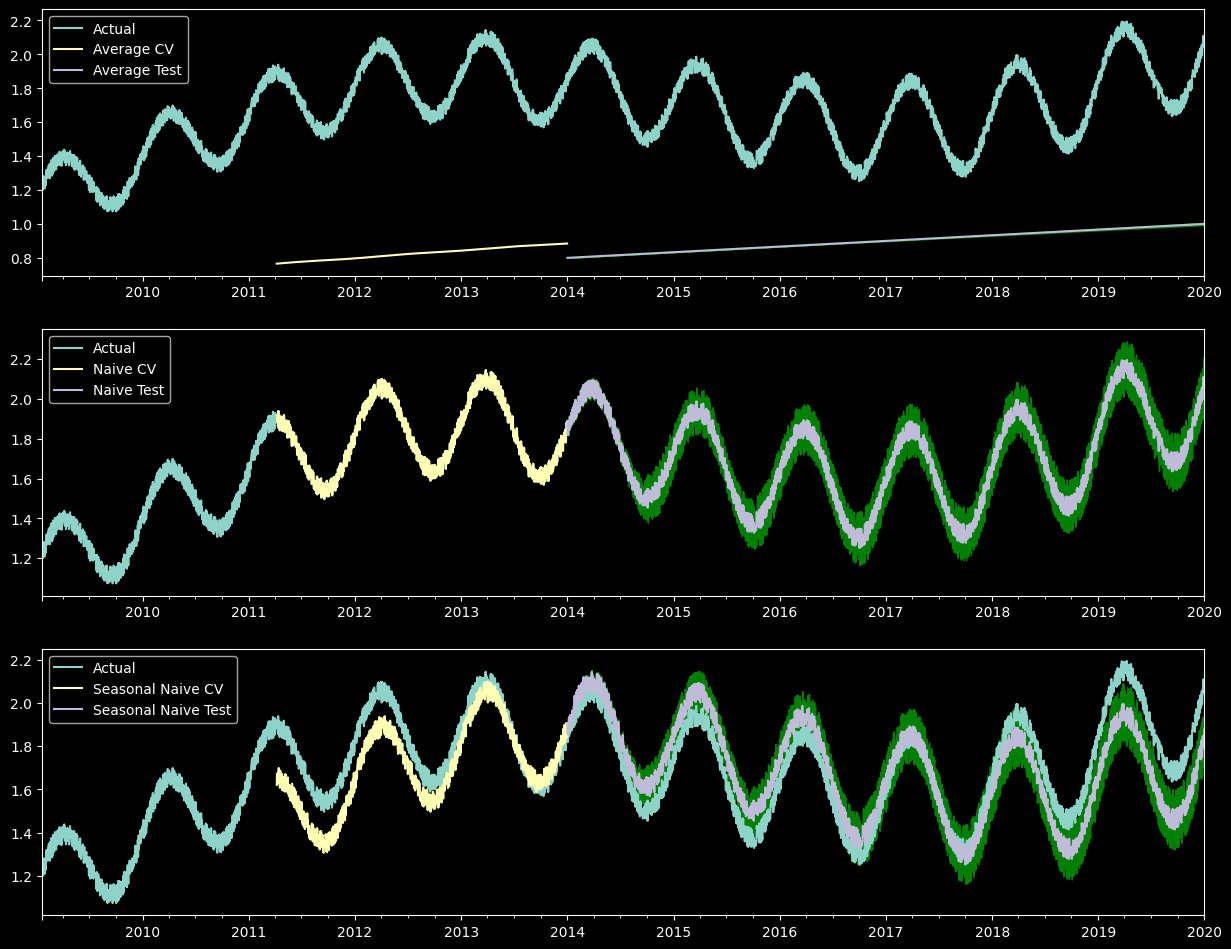

In [406]:
fig, axes = plt.subplots(3,1, figsize=(15,12))

# Plot the Actual Series
combined_msheet[['Actual', 'Average CV', 'Average Test']].plot(ax=axes[0])
axes[0].fill_between(combined_msheet['Average UL'].dropna().index,
                 combined_msheet['Average UL'].dropna(),
                 combined_msheet['Average LL'].dropna(), color='g')
# Plot for Naive Model
combined_msheet[['Actual', 'Naive CV', 'Naive Test']].plot(ax=axes[1])
axes[1].fill_between(combined_msheet['Naive UL'].dropna().index,
                 combined_msheet['Naive UL'].dropna(),
                 combined_msheet['Naive LL'].dropna(), color='g')
# Plot for Seasonal Naive Model
combined_msheet[['Actual', 'Seasonal Naive CV', 'Seasonal Naive Test']].plot(ax=axes[2])
axes[2].fill_between(combined_msheet['Seasonal Naive UL'].dropna().index,
                 combined_msheet['Seasonal Naive UL'].dropna(),
                 combined_msheet['Seasonal Naive LL'].dropna(), color='g')

# AR & MA Processes


# ARIMA Model

# Linear Regression

# Model Comparision

- AIC
- BIC
- [DIC](https://www.youtube.com/watch?v=xS4jDHQfP2o)
- [WAIC](https://www.youtube.com/watch?v=xS4jDHQfP2o)

# Random Testing Space